In [97]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report
)

In [98]:
df = pd.read_csv("../../data/processed/telco_clean.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,1,...,1,1,1,1,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,2,...,2,1,1,1,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,2,...,1,1,1,1,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,2,...,2,2,1,1,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,1,...,1,1,1,1,Month-to-month,1,Electronic check,70.70,151.65,1


In [99]:
X = df.drop(columns=['Churn','customerID'])
y = df['Churn']
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns
categorical_cols, numerical_cols

(Index(['gender', 'MultipleLines', 'InternetService', 'Contract',
        'PaymentMethod'],
       dtype='object'),
 Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
        'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges',
        'TotalCharges'],
       dtype='object'))

In [100]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [101]:
df = df.reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [102]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb_model)
])


In [103]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [104]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.783226723525231
Precision: 0.6048632218844985
Recall: 0.5320855614973262
F1 Score: 0.566145092460882
ROC AUC: 0.8322276635726894

Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.60      0.53      0.57       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.78      0.78      0.78      1407



In [105]:
import joblib

joblib.dump(model, "../../artifacts/xgb_model.pkl")

np.save("../../artifacts/xgb_y_pred.npy", y_pred)
np.save("../../artifacts/xgb_y_proba.npy", y_pred_proba)


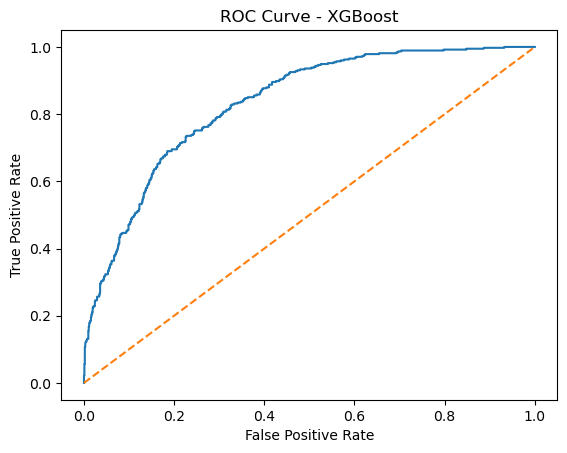

In [107]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.show()